In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.integrate import quad

First we will create a class of function Generator, Which will generate psudo-experiment data. Each instantiation of class can be given 7 class variables.

minimum and maximum values of experiment data required, number of data observed, three parameters of function (to be discussed below) and time resolution factor.

In [2]:
class function_generator:
    
    def __init__(self,x_min,x_max,n_signal,life_time,V_parm,del_m_parm,time_res_fraction):
        self.x_min=x_min
        self.x_max=x_max
        self.n_signal=n_signal
        self.life_time=life_time
        self.V_parm=V_parm
        self.del_m_parm=del_m_parm
        self.time_res_fraction=time_res_fraction
    
    #It is box method to generate random data folloing the given function.
    def funct_dataset(self):
        i=0
        data=[]
        
        #Here we define the function required.
        def syst_funct(x_data,x_min,x_max,V_parm,del_m_parm,life_time):
            p = (1+self.V_parm*np.sin(self.del_m_parm*x_data))*np.exp(-x_data/self.life_time)
            return p
        
        #We also need maxima of function, in box method, to generate random number.
        x = np.arange(self.x_min,self.x_max,0.01)
        y = syst_funct(x,self.x_min,self.x_max,self.V_parm,self.del_m_parm,self.life_time)
        max_funct = max(y)
        
        #following the the standard method to generate random number in the box.
        while i<self.n_signal:
            x=np.random.uniform(self.x_min,self.x_max)
            if syst_funct(x,self.x_min,self.x_max,self.V_parm,self.del_m_parm,self.life_time)>np.random.uniform(0,max_funct):
                 data.append(x)
                 i +=1
                
        #Output from box method will be subjected to time resolution smeearing        
        return np.random.normal(data,self.life_time*self.time_res_fraction)
        
        #Note: If time resolution factor is 0, there will no time resolution effect.
    

Defining a normalised function describing the physics of experiment. This function will be used multiple times in the anaysis.

In [ ]:
def funct_sys(x,life_time,V_parm,del_m_parm):
    def funct(x,life_time,V_parm,del_m_parm):
        return (1+V_parm*np.sin(del_m_parm*x))*np.exp(-x/life_time)
    def funct_nor(x):
        return quad(funct,0,10,args=(life_time,V_parm,del_m_parm))   
    return funct(x,life_time,V_parm,del_m_parm)/funct_nor(x)[0]

# Question 1 a)

We will generate a psudo-experiment data with 10,000 events and determine the expected statistical precision with which one could measure each of the parameters with.

Generation first data set, using class function_generator

In [3]:
first=function_generator(0,10,10000,1.5,0.1,20,0)
#10,000 events generated from 0 to 10, with given parameters as desired.

dat=np.array(first.funct_dataset())

Comparing the data generated to the function defining physics of system. (Just a visual check)

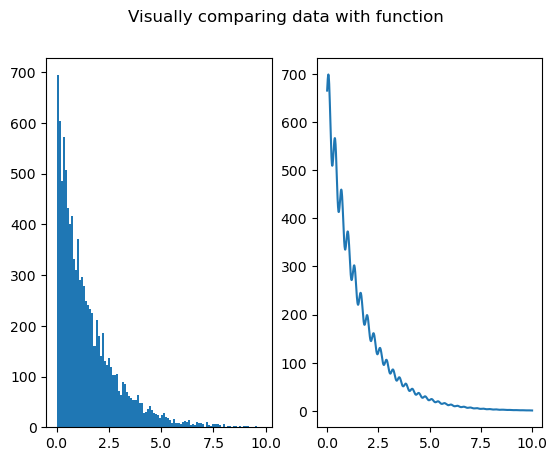

In [4]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Visually comparing data with function')
axs[0].hist(dat,bins=100)

x = np.arange(0,10,0.01)  
y = funct_sys(x,1.5,0.1,20)*1000

axs[1].plot(x,y)
plt.show()

Now we will define NLL function, which will be minimised to estimate the parameters.

We will define NLL multiple times, but the algorith would be same, and it will be fed with different data-sets. so we will use index (1,2,3,...) to keep track of them.

We will use Minuit minimizer for our analysis.

In [5]:
def fnct1(life_time,V_parm,del_m_parm):
    pdf = funct_sys(dat,life_time,V_parm,del_m_parm)
    pdf=np.maximum(pdf,0.0001)
    return -np.sum(np.log(pdf))

les=Minuit(fnct1,life_time=1.5,V_parm=0.1,del_m_parm=20)
les.errordef=0.5
les.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.385e+04                  │              Nfcn = 49               │
│ EDM = 1.56e-06 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ life_time  │   1.495   │   0.015   │            │            │         │         │       │
│ 1 │ V_parm     │   0.117   │   0.014   │            │            │         │         │       │
│ 2 │ del_m_parm │   20.14   │   0.06    │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬──────────────────────────────────┐
│            │  life_time     V_parm del_m_parm │
├────────────┼──────────────────────────────────┤
│  life_time │   0.000237   1.04e-05  -2.14e-06 │
│     V_parm │   1.04e-05   0.000201  -7.32e-06 │
│ del_m_parm │  -2.14e-06  -7.32e-06    0.00413 │
└────────────┴──────────────────────────────────┘

We will follow the same recipe, 500 time to get confidence in results.

In [16]:
data_lifetime_1=[]
data_V_parm_1=[]
data_del_m_parm_1=[]
n=0
for i in range(500):
   
    first=function_generator(0,10,10000,1.5,0.1,20,0)
    dat=np.array(first.funct_dataset())
    
    def fnct1(life_time,V_parm,del_m_parm):
        pdf = funct_sys(dat,life_time,V_parm,del_m_parm)
        pdf=np.maximum(pdf,0.0001)
        return -np.sum(np.log(pdf))
    
    les=Minuit(fnct1,life_time=1.5,V_parm=0.1,del_m_parm=20)
    les.errordef=0.5
    les.migrad()
    n  += 1
    
    #Keeping track of results from every single estimation.
    data_lifetime_1.append(les.values[0])
    data_V_parm_1.append(les.values[1])
    data_del_m_parm_1.append(les.values[2])
    print(f'{n})  life time = {les.values[0]},  V parameter = {les.values[1]}, del_m parameter ={les.values[2]}')

1)  life time = 1.4796059093783294,  V parameter = 0.11036014936012757, del_m parameter =19.99991896137272
2)  life time = 1.5000052228113077,  V parameter = 0.10732844101390941, del_m parameter =20.047366792026256
3)  life time = 1.5239555728129979,  V parameter = 0.0849217120074079, del_m parameter =19.804458953286947
4)  life time = 1.463075218455058,  V parameter = 0.08985102089508804, del_m parameter =20.057171579040062
5)  life time = 1.503418657505714,  V parameter = 0.092807023178878, del_m parameter =19.960710872268177
6)  life time = 1.503825374657177,  V parameter = 0.08066124637339853, del_m parameter =20.049723129184116
7)  life time = 1.4911561286829298,  V parameter = 0.07748418044041501, del_m parameter =20.201550444638958
8)  life time = 1.4991473509544466,  V parameter = 0.08746079414287636, del_m parameter =20.0701356623307
9)  life time = 1.50109601944628,  V parameter = 0.11086627980665574, del_m parameter =20.012925255741035
10)  life time = 1.4861889540128805,  V

77)  life time = 1.5192024784713196,  V parameter = 0.09102090204344382, del_m parameter =20.018895522684524
78)  life time = 1.502358614258426,  V parameter = 0.11160801758513679, del_m parameter =19.914957912574547
79)  life time = 1.491453009724733,  V parameter = 0.08450428953868966, del_m parameter =19.966086115130853
80)  life time = 1.5015558984772825,  V parameter = 0.1227146567677384, del_m parameter =20.10320740202588
81)  life time = 1.4872766638597321,  V parameter = 0.10536289198505137, del_m parameter =19.932751876121017
82)  life time = 1.4868352134293625,  V parameter = 0.10614283132476289, del_m parameter =20.00301365171037
83)  life time = 1.5044971355676091,  V parameter = 0.07898433140614929, del_m parameter =20.15426457184433
84)  life time = 1.4982523717153748,  V parameter = 0.11568807973929754, del_m parameter =20.023125717994784
85)  life time = 1.503601436848085,  V parameter = 0.07982612645277755, del_m parameter =19.915939773928425
86)  life time = 1.5127468

153)  life time = 1.4915830417965024,  V parameter = 0.07979635935067173, del_m parameter =20.026934546024226
154)  life time = 1.5112833120113143,  V parameter = 0.10433564853081499, del_m parameter =20.03580975951205
155)  life time = 1.5078740875142471,  V parameter = 0.09904265956736229, del_m parameter =20.006069880424633
156)  life time = 1.4951502979979163,  V parameter = 0.0848434014590692, del_m parameter =19.795556962587312
157)  life time = 1.5010739736602687,  V parameter = 0.1302958861541236, del_m parameter =19.951960221260038
158)  life time = 1.5359372494472123,  V parameter = 0.11735751174044777, del_m parameter =19.876367578220055
159)  life time = 1.5256465495546045,  V parameter = 0.10411465213262332, del_m parameter =20.073008680829084
160)  life time = 1.5339138502571816,  V parameter = 0.10850881058382307, del_m parameter =19.944258095144377
161)  life time = 1.5061987471256342,  V parameter = 0.08899151247058289, del_m parameter =19.977347790093532
162)  life ti

229)  life time = 1.4790061454845524,  V parameter = 0.07769845131443921, del_m parameter =20.175741622584475
230)  life time = 1.4934806473550177,  V parameter = 0.08835363542872825, del_m parameter =20.161234669879537
231)  life time = 1.4738991533553627,  V parameter = 0.10787102591118454, del_m parameter =20.080962592510016
232)  life time = 1.4770106406772743,  V parameter = 0.08381171176023879, del_m parameter =19.881160853840385
233)  life time = 1.4916594485713937,  V parameter = 0.09749644886306677, del_m parameter =19.99891929291817
234)  life time = 1.507368927044688,  V parameter = 0.11571718287943371, del_m parameter =19.992118229872197
235)  life time = 1.5015760624879655,  V parameter = 0.11293963530747321, del_m parameter =20.03770375188408
236)  life time = 1.5161877331017688,  V parameter = 0.10222745940333107, del_m parameter =19.872714472494632
237)  life time = 1.5003773428679974,  V parameter = 0.09735847155162126, del_m parameter =20.0195197725141
238)  life time

304)  life time = 1.4931023382274995,  V parameter = 0.10581941178597536, del_m parameter =19.917718954156417
305)  life time = 1.4927384404653732,  V parameter = 0.11462569502143785, del_m parameter =20.148895944895905
306)  life time = 1.5195833406231385,  V parameter = 0.07622855389470952, del_m parameter =19.974563970986292
307)  life time = 1.4923265734172753,  V parameter = 0.08133419069459968, del_m parameter =19.991959651710776
308)  life time = 1.4711487963109515,  V parameter = 0.08417102277706354, del_m parameter =19.909545409167315
309)  life time = 1.5346847659653557,  V parameter = 0.1017349030735927, del_m parameter =19.982929907019308
310)  life time = 1.4938284366710077,  V parameter = 0.10622995859874944, del_m parameter =19.937210569565497
311)  life time = 1.5130688388204863,  V parameter = 0.09242805287391571, del_m parameter =19.926504854700216
312)  life time = 1.4863311264380854,  V parameter = 0.10639771299527369, del_m parameter =20.109119053696176
313)  life 

380)  life time = 1.4835914917353792,  V parameter = 0.09646387456442834, del_m parameter =19.965391551657277
381)  life time = 1.498851647412965,  V parameter = 0.08865419359073222, del_m parameter =20.073799035845926
382)  life time = 1.4859068328515694,  V parameter = 0.09433913632775812, del_m parameter =20.01962549718154
383)  life time = 1.4874497421359298,  V parameter = 0.09729356679175867, del_m parameter =20.041987909242263
384)  life time = 1.4774837685603792,  V parameter = 0.0958194267323724, del_m parameter =19.92059321303446
385)  life time = 1.5191412427015274,  V parameter = 0.07309701314958555, del_m parameter =19.930113421026736
386)  life time = 1.491298807290359,  V parameter = 0.08842087150061699, del_m parameter =19.944141857607462
387)  life time = 1.5029618259274722,  V parameter = 0.11368497825465758, del_m parameter =20.209247840945082
388)  life time = 1.4884393874944564,  V parameter = 0.10741702257489932, del_m parameter =20.010283365776893
389)  life time

455)  life time = 1.472179694930955,  V parameter = 0.09841364848959173, del_m parameter =19.824478088969798
456)  life time = 1.4867198160500532,  V parameter = 0.10098802307206108, del_m parameter =19.981773905216894
457)  life time = 1.5014585163863843,  V parameter = 0.098271963178092, del_m parameter =19.83667004918056
458)  life time = 1.483714621578028,  V parameter = 0.0985016419589956, del_m parameter =19.880589933903384
459)  life time = 1.516737831592782,  V parameter = 0.12356595616475366, del_m parameter =20.00107936918384
460)  life time = 1.4984014419838412,  V parameter = 0.11581756326389522, del_m parameter =20.1157475819831
461)  life time = 1.5056319435407886,  V parameter = 0.131235427881539, del_m parameter =19.957820251324137
462)  life time = 1.5191450930728376,  V parameter = 0.11131282846172044, del_m parameter =19.96153702060745
463)  life time = 1.4955483990905782,  V parameter = 0.07438445439985736, del_m parameter =19.89775036352618
464)  life time = 1.5003

Interpetation of results.

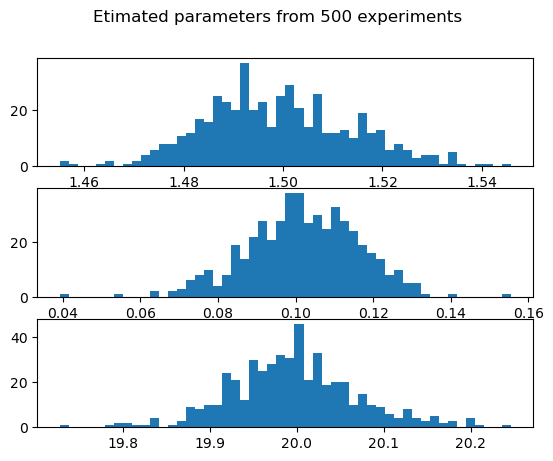

Estimated life time parameter is   =  1.499 +- 0.015 
Estimated V parameter is   =  0.102 +- 0.014 
Estimated del parameter is   =  19.997 +- 0.074 


In [54]:
fig, axs = plt.subplots(3)
fig.suptitle('Etimated parameters from 500 experiments')
axs[0].hist(data_lifetime_1,bins=50)
axs[1].hist(data_V_parm_1,bins=50)
axs[2].hist(data_del_m_parm_1,bins=50)
plt.show()

print(f'Estimated life time parameter is   =  {np.mean(data_lifetime_1):.3f} +- {np.std(data_lifetime_1):.3f} ')
print(f'Estimated V parameter is   =  {np.mean(data_V_parm_1):.3f} +- {np.std(data_V_parm_1):.3f} ')
print(f'Estimated del parameter is   =  {np.mean(data_del_m_parm_1):.3f} +- {np.std(data_del_m_parm_1):.3f} ')

It was expected that while repeating experiments, statistical precision will not be affected. And our statistical precesion(error) is same as obtained with Minuit.

# Question 1  b)

We will repeat the same procedure with 100,000 events this time.

In [9]:
second=function_generator(0,10,100000,1.5,0.1,20,0)
dat2=np.array(second.funct_dataset())

def fnct2(life_time,V_parm,del_m_parm):
    pdf = funct_sys(dat2,life_time,V_parm,del_m_parm)
    pdf=np.maximum(pdf,0.0001)
    return -np.sum(np.log(pdf))

les=Minuit(fnct2,life_time=1.5,V_parm=0.1,del_m_parm=20)
les.errordef=0.5
les.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.394e+05                  │              Nfcn = 47               │
│ EDM = 5.52e-06 (Goal: 0.0001)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ life_time  │   1.506   │   0.005   │            │            │         │         │       │
│ 1 │ V_parm     │   0.099   │   0.004   │            │            │         │         │       │
│ 2 │ del_m_parm │  19.977   │   0.022   │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬──────────────────────────────────┐
│            │  life_time     V_parm del_m_parm │
├────────────┼──────────────────────────────────┤
│  life_time │   2.41e-05   1.05e-06   2.58e-08 │
│     V_parm │   1.05e-06   2.01e-05  -5.42e-07 │
│ del_m_parm │   2.58e-08  -5.42e-07   0.000471 │
└────────────┴──────────────────────────────────┘

This time we will be doing 50 experiments. (Saving computation time)

In [10]:
data_lifetime_2=[]
data_V_parm_2=[]
data_del_m_parm_2=[]
n=0
for i in range(50):
   
    first=function_generator(0,10,100000,1.5,0.1,20,0)
    dat=np.array(first.funct_dataset())
    
    def fnct1(life_time,V_parm,del_m_parm):
        pdf = funct_sys(dat,life_time,V_parm,del_m_parm)
        pdf=np.maximum(pdf,0.0001)
        return -np.sum(np.log(pdf))
    
    les1=Minuit(fnct1,life_time=1.5,V_parm=0.1,del_m_parm=20)
    les1.errordef=0.5
    les1.migrad()
    n  += 1
    
    
    data_lifetime_2.append(les1.values[0])
    data_V_parm_2.append(les1.values[1])
    data_del_m_parm_2.append(les1.values[2])
    print(f'{n})  life time = {les1.values[0]},  V parameter = {les1.values[1]}, del_m parameter ={les1.values[2]}')

1)  life time = 1.492129991847628,  V parameter = 0.09832707632075911, del_m parameter =19.985011306309495
2)  life time = 1.4974731708805722,  V parameter = 0.09928098595862991, del_m parameter =20.011562942495384
3)  life time = 1.4948589461197284,  V parameter = 0.10279934052161745, del_m parameter =19.954408705296288
4)  life time = 1.5104781413158526,  V parameter = 0.09747687308427053, del_m parameter =19.998827854373072
5)  life time = 1.4982006208151204,  V parameter = 0.10434339535467443, del_m parameter =20.0039251049589
6)  life time = 1.4969247216693156,  V parameter = 0.09769555638622691, del_m parameter =19.968169303975326
7)  life time = 1.5109448101610405,  V parameter = 0.10722824851298127, del_m parameter =20.019930231396508
8)  life time = 1.5024374761635604,  V parameter = 0.0955494529626102, del_m parameter =19.97751452357894
9)  life time = 1.5008819434424956,  V parameter = 0.10005289959657249, del_m parameter =19.970643081798798
10)  life time = 1.49225564176493

Interpeting results

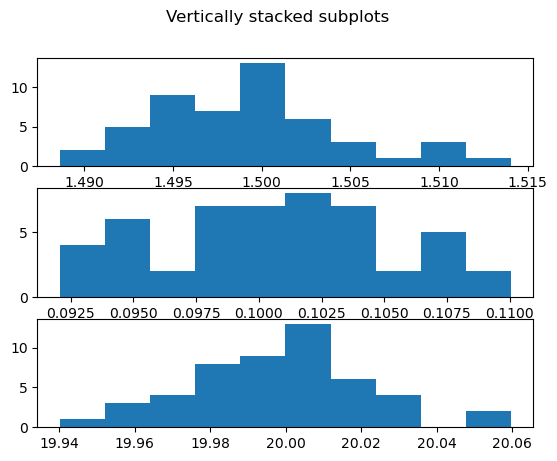

life time is     = 1.499 +- 0.005 
V parameter is   =  0.100 +- 0.005 
del parameter is =  20.00 +- 0.02 


In [23]:
fig, axs = plt.subplots(3)
fig.suptitle('Etimated parameters from 50 experiments')
axs[0].hist(data_lifetime_2,bins=10)
axs[1].hist(data_V_parm_2,bins=10)
axs[2].hist(data_del_m_parm_2,bins=10)
plt.show()


print(f'life time is     = {np.mean(data_lifetime_2):.3f} +- {np.std(data_lifetime_2):.3f} ')
print(f'V parameter is   =  {np.mean(data_V_parm_2):.3f} +- {np.std(data_V_parm_2):.3f} ')
print(f'del parameter is =  {np.mean(data_del_m_parm_2):.2f} +- {np.std(data_del_m_parm_2):.2f} ')

Hence by increasing number of events in single experiment we can reduce the statistical error from the parameters estimated.

# Question 2   a)

Estimating possible bias due to time resolution

Decay time is measured with a resolution (random error) with a standard deviation of of σ = fτ. this means is that if the true decay time is t true, then it is actually measured as t where t is distributed around t true with a Gaussian probability distribution with standard deviation σ.

While generating psudo-experiment data. we will we using time resolution factor in class.  ie f=0.01

In [12]:
data3=function_generator(0,10,10000,1.5,0.1,20,0.01)
dat3=np.array(first.funct_dataset())

minimisaing paramets folloing the lines of first question.

In [13]:
def fnct3(life_time,V_parm,del_m_parm):
    pdf = funct_sys(dat3,life_time,V_parm,del_m_parm)
    pdf=np.maximum(pdf,0.0001)
    return -np.sum(np.log(pdf))

les3=Minuit(fnct1,life_time=1.5,V_parm=0.1,del_m_parm=20)
les3.errordef=0.5
les3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.384e+05                  │              Nfcn = 47               │
│ EDM = 1.79e-06 (Goal: 0.0001)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ life_time  │   1.492   │   0.005   │            │            │         │         │       │
│ 1 │ V_parm     │   0.102   │   0.004   │            │            │         │         │       │
│ 2 │ del_m_parm │  20.016   │   0.021   │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬──────────────────────────────────┐
│            │  life_time     V_parm del_m_parm │
├────────────┼──────────────────────────────────┤
│  life_time │   2.36e-05   1.05e-06  -1.45e-08 │
│     V_parm │   1.05e-06   2.01e-05  -5.55e-07 │
│ del_m_parm │  -1.45e-08  -5.55e-07   0.000444 │
└────────────┴──────────────────────────────────┘

Using same on 500 different data points

In [19]:
data_lifetime_3=[]
data_V_parm_3=[]
data_del_m_parm_3=[]
n=0
for i in range(500):
   
    first=function_generator(0,10,10000,1.5,0.1,20,0.01)
    dat=np.array(first.funct_dataset())
    
    def fnct1(life_time,V_parm,del_m_parm):
        pdf = funct_sys(dat,life_time,V_parm,del_m_parm)
        pdf=np.maximum(pdf,0.0001)
        return -np.sum(np.log(pdf))
    
    les1=Minuit(fnct1,life_time=1.5,V_parm=0.1,del_m_parm=20)
    les1.errordef=0.5
    les1.migrad()
    n  += 1
    
    
    data_lifetime_3.append(les1.values[0])
    data_V_parm_3.append(les1.values[1])
    data_del_m_parm_3.append(les1.values[2])
    print(f'{n})  life time = {les1.values[0]},  V parameter = {les1.values[1]}, del_m parameter ={les1.values[2]}')

1)  life time = 1.5175653890269052,  V parameter = 0.08119973834365177, del_m parameter =20.092139395904088
2)  life time = 1.488940917569881,  V parameter = 0.07470424400233487, del_m parameter =20.058040028961827
3)  life time = 1.5070677800870258,  V parameter = 0.07406271145456059, del_m parameter =19.733140862431398
4)  life time = 1.5165080275451803,  V parameter = 0.09541147872430784, del_m parameter =20.07667344765401
5)  life time = 1.5099132193304552,  V parameter = 0.12003540385790122, del_m parameter =19.987718054332777
6)  life time = 1.5000466175915395,  V parameter = 0.10798151964206892, del_m parameter =19.878273520720768
7)  life time = 1.5110097879177646,  V parameter = 0.12219296580475451, del_m parameter =20.11677163281766
8)  life time = 1.491626384479585,  V parameter = 0.10791598202044744, del_m parameter =19.94592237261505
9)  life time = 1.4952447907440831,  V parameter = 0.1033948654903375, del_m parameter =19.905502206444318
10)  life time = 1.502922276743175

77)  life time = 1.499915256757956,  V parameter = 0.11687288513726507, del_m parameter =20.018729846807535
78)  life time = 1.504060738471954,  V parameter = 0.08758921879780968, del_m parameter =20.081382456946052
79)  life time = 1.4924915004119172,  V parameter = 0.09085967385954767, del_m parameter =19.89138874374861
80)  life time = 1.5092769144933815,  V parameter = 0.10734253188861737, del_m parameter =20.061992614214386
81)  life time = 1.4774950944729637,  V parameter = 0.07870929561056447, del_m parameter =20.030023714666008
82)  life time = 1.515349582199101,  V parameter = 0.10076912256627008, del_m parameter =19.98816282056111
83)  life time = 1.5322782981113805,  V parameter = 0.09659840990747744, del_m parameter =20.137940212946933
84)  life time = 1.4831455519882364,  V parameter = 0.10015771183931962, del_m parameter =19.98597539936653
85)  life time = 1.5096920453870717,  V parameter = 0.11074126986270591, del_m parameter =20.046912420865524
86)  life time = 1.507230

153)  life time = 1.5165297556696096,  V parameter = 0.0966912418162631, del_m parameter =19.97192314639058
154)  life time = 1.5143916512828712,  V parameter = 0.0625793213482867, del_m parameter =19.94862093145795
155)  life time = 1.4800959435139212,  V parameter = 0.08804595148547811, del_m parameter =19.850437399792998
156)  life time = 1.4734692303838735,  V parameter = 0.10270699866367779, del_m parameter =20.06309402764535
157)  life time = 1.5109407704151034,  V parameter = 0.07832973409798837, del_m parameter =20.02244034618203
158)  life time = 1.5122653931523224,  V parameter = 0.088347195555721, del_m parameter =19.945165143017032
159)  life time = 1.4923290895078645,  V parameter = 0.09779507780198049, del_m parameter =20.061983045032257
160)  life time = 1.511235603852771,  V parameter = 0.08411186576126459, del_m parameter =20.035490381234553
161)  life time = 1.5069467701254151,  V parameter = 0.12448123037567435, del_m parameter =20.052644045345957
162)  life time = 1

229)  life time = 1.5009136533279601,  V parameter = 0.10813447361515792, del_m parameter =20.208675200122393
230)  life time = 1.482025840294276,  V parameter = 0.10013626682701156, del_m parameter =20.047402276762906
231)  life time = 1.5121998471510794,  V parameter = 0.10764616602107865, del_m parameter =19.970857863417276
232)  life time = 1.5114604406244432,  V parameter = 0.1248541001415598, del_m parameter =19.962996644540038
233)  life time = 1.5067288849253286,  V parameter = 0.09721531355395642, del_m parameter =20.071524943405784
234)  life time = 1.5101505614852764,  V parameter = 0.09657970776117598, del_m parameter =20.031248555127057
235)  life time = 1.486245390966755,  V parameter = 0.10868505165025026, del_m parameter =19.955292013492848
236)  life time = 1.4912561462373597,  V parameter = 0.0771437513379406, del_m parameter =19.861945087197448
237)  life time = 1.4987333541902745,  V parameter = 0.06855025055126797, del_m parameter =19.891438653063293
238)  life tim

304)  life time = 1.4801071630911362,  V parameter = 0.06286538832798981, del_m parameter =20.066127143163055
305)  life time = 1.5289441397444203,  V parameter = 0.10588453891539563, del_m parameter =19.90975133798122
306)  life time = 1.5139382312339442,  V parameter = 0.12681020292878453, del_m parameter =20.111459821718267
307)  life time = 1.4932312040802713,  V parameter = 0.10711978153904973, del_m parameter =20.027510456440062
308)  life time = 1.5430845795676134,  V parameter = 0.10051685388381884, del_m parameter =20.115937134783785
309)  life time = 1.4797576779904806,  V parameter = 0.1091625143477974, del_m parameter =20.076721461871923
310)  life time = 1.4783526093034773,  V parameter = 0.09537111235162754, del_m parameter =20.043373558989387
311)  life time = 1.5060304787946892,  V parameter = 0.10673914903346235, del_m parameter =19.94596138597396
312)  life time = 1.478549378847755,  V parameter = 0.08309550625386165, del_m parameter =20.059867809309186
313)  life tim

379)  life time = 1.4896562745475237,  V parameter = 0.06742073803446769, del_m parameter =19.928524189343914
380)  life time = 1.4976487599473478,  V parameter = 0.07999308156173227, del_m parameter =19.928857253662326
381)  life time = 1.5133497226872539,  V parameter = 0.11172758594715287, del_m parameter =19.971951061581102
382)  life time = 1.5057265492155958,  V parameter = 0.09840452898446647, del_m parameter =19.908842179103825
383)  life time = 1.480760153502915,  V parameter = 0.08678099338677023, del_m parameter =20.056740690384103
384)  life time = 1.5024167112604072,  V parameter = 0.08002092489116527, del_m parameter =20.015778351909834
385)  life time = 1.4848325836078287,  V parameter = 0.09568948480411837, del_m parameter =19.989210862492968
386)  life time = 1.485481132781895,  V parameter = 0.12272265708180134, del_m parameter =20.060643853638133
387)  life time = 1.4832295418371595,  V parameter = 0.08268675943814201, del_m parameter =20.06568926412888
388)  life ti

455)  life time = 1.5221326632912704,  V parameter = 0.09852462189885322, del_m parameter =20.088758696879474
456)  life time = 1.5026873167174601,  V parameter = 0.10671461140505087, del_m parameter =20.06627300628684
457)  life time = 1.4958464805180136,  V parameter = 0.08997575037669486, del_m parameter =20.05615035758921
458)  life time = 1.4905519160315002,  V parameter = 0.08607452439054018, del_m parameter =19.93928090594612
459)  life time = 1.508016116923005,  V parameter = 0.0932597230837466, del_m parameter =20.00440127238837
460)  life time = 1.4945566717294465,  V parameter = 0.0775618869402313, del_m parameter =19.93084540179203
461)  life time = 1.5135084597504533,  V parameter = 0.11312262506787257, del_m parameter =20.061881137028188
462)  life time = 1.4881189857952017,  V parameter = 0.07438418519876185, del_m parameter =20.045168332586364
463)  life time = 1.5076590560953869,  V parameter = 0.10068982503162185, del_m parameter =19.91918445442548
464)  life time = 1

Interpeting results

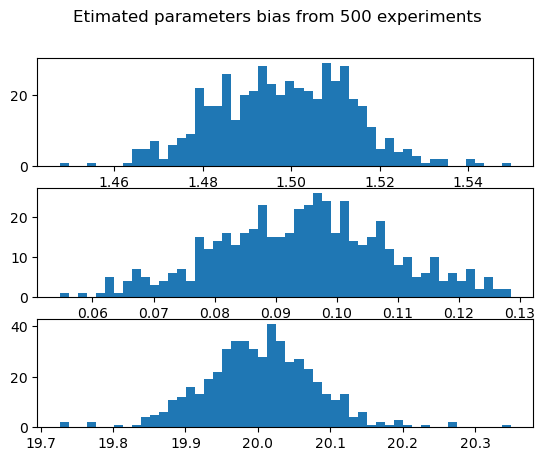

life time bias has a bias of -0.001 with bias precesion of 0.001
V parameter has a bias of  -0.008  with bias precesion of 0.001
del parameter has a bias of  0.006  with bias precesion of 0.003


In [55]:
fig, axs = plt.subplots(3)
fig.suptitle('Etimated parameters bias from 500 experiments')
axs[0].hist(data_lifetime_3,bins=50)
axs[1].hist(data_V_parm_3,bins=50)
axs[2].hist(data_del_m_parm_3,bins=50)
plt.show()

print(f'life time bias has a bias of {np.mean(data_lifetime_3)-np.mean(data_lifetime_1):.3f} with bias precesion of {(np.std(data_lifetime_3)/np.sqrt(500)):.3f}')
print(f'V parameter has a bias of  {np.mean(data_V_parm_3)-np.mean(data_V_parm_1):.3f}  with bias precesion of {np.std(data_V_parm_3)/np.sqrt(500):.3f}')
print(f'del parameter has a bias of  {np.mean(data_del_m_parm_3)-np.mean(data_del_m_parm_1):.3f}  with bias precesion of {np.std(data_del_m_parm_3)/np.sqrt(500):.3f}')

When time resolution is introduced. Then there will be follwing bias in our estimation. This bias can be eliminated up till some bias precision by adding the bias to finally estimated parameters.

We observe the significant bias only on V paramer. which is expected(see next section)

# Question 2  b)

Generating different dataset with f=0.03 and doing the same analysis as we have been doing in above question.

In [16]:
fourth=function_generator(0,10,10000,1.5,0.1,20,0.03)
dat4=np.array(first.funct_dataset())

def fnct4(life_time,V_parm,del_m_parm):
    pdf = funct_sys(dat4,life_time,V_parm,del_m_parm)
    pdf=np.maximum(pdf,0.0001)
    return -np.sum(np.log(pdf))

les1=Minuit(fnct4,life_time=1.5,V_parm=0.1,del_m_parm=20)
les1.errordef=0.5
les1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.384e+04                  │              Nfcn = 53               │
│ EDM = 1.06e-07 (Goal: 0.0001)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ life_time  │   1.489   │   0.015   │            │            │         │         │       │
│ 1 │ V_parm     │   0.080   │   0.014   │            │            │         │         │       │
│ 2 │ del_m_parm │   20.07   │   0.08    │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬──────────────────────────────────┐
│            │  life_time     V_parm del_m_parm │
├────────────┼──────────────────────────────────┤
│  life_time │   0.000235   1.04e-05   -2.9e-07 │
│     V_parm │   1.04e-05     0.0002   6.05e-06 │
│ del_m_parm │   -2.9e-07   6.05e-06    0.00624 │
└────────────┴──────────────────────────────────┘

Performing monte carlo 500 times.

In [25]:
data_lifetime_4=[]
data_V_parm_4=[]
data_del_m_parm_4=[]
n=0
for i in range(500):
   
    first=function_generator(0,10,10000,1.5,0.1,20,0.03)
    dat=np.array(first.funct_dataset())
    
    def fnct1(life_time,V_parm,del_m_parm):
        pdf = funct_sys(dat,life_time,V_parm,del_m_parm)
        pdf=np.maximum(pdf,0.0001)
        return -np.sum(np.log(pdf))
    
    les1=Minuit(fnct1,life_time=1.5,V_parm=0.1,del_m_parm=20)
    les1.errordef=0.5
    les1.migrad()
    n  += 1
    
    data_lifetime_4.append(les1.values[0])
    data_V_parm_4.append(les1.values[1])
    data_del_m_parm_4.append(les1.values[2])
    print(f'{n})  life time = {les1.values[0]},  V parameter = {les1.values[1]}, del_m parameter ={les1.values[2]}')

1)  life time = 1.4975599511460695,  V parameter = 0.0572710892446791, del_m parameter =20.151769726389627
2)  life time = 1.4821621022733185,  V parameter = 0.050846917756400836, del_m parameter =19.911941610396656
3)  life time = 1.4886312888329345,  V parameter = 0.06212435393899384, del_m parameter =19.959780169688027
4)  life time = 1.5096357220820478,  V parameter = 0.06628560771644834, del_m parameter =20.064290276709823
5)  life time = 1.5109737224232938,  V parameter = 0.03925710730895206, del_m parameter =20.135049296790346
6)  life time = 1.4894055705217641,  V parameter = 0.039841855342642264, del_m parameter =19.844908237370042
7)  life time = 1.5390862026631398,  V parameter = 0.061494548073539865, del_m parameter =19.725471471936515
8)  life time = 1.5212819246440967,  V parameter = 0.03614866249667401, del_m parameter =19.757789456770745
9)  life time = 1.4910941307660595,  V parameter = 0.034167626254690345, del_m parameter =20.005637328099354
10)  life time = 1.496195

77)  life time = 1.4892672140001346,  V parameter = 0.04985020012556353, del_m parameter =19.852603440172405
78)  life time = 1.4904824990158356,  V parameter = 0.04966317429212124, del_m parameter =19.95408684384358
79)  life time = 1.4962238386841182,  V parameter = 0.02503127065757695, del_m parameter =20.0779689077584
80)  life time = 1.4831639443965376,  V parameter = 0.049951881321896284, del_m parameter =19.982211816502463
81)  life time = 1.4859509212509812,  V parameter = 0.04685627721311796, del_m parameter =20.007300766715733
82)  life time = 1.496158136963573,  V parameter = 0.037985333841193486, del_m parameter =20.084204329686468
83)  life time = 1.514974237199144,  V parameter = 0.033206909851978814, del_m parameter =19.980871669046753
84)  life time = 1.483320312439176,  V parameter = 0.05306122226788934, del_m parameter =19.99952854929499
85)  life time = 1.4893528197565897,  V parameter = 0.04520155244427987, del_m parameter =19.949591132437416
86)  life time = 1.5155

153)  life time = 1.4852520434789038,  V parameter = 0.03831386269361911, del_m parameter =19.98089091574914
154)  life time = 1.4823103566480396,  V parameter = 0.03628282775113234, del_m parameter =19.9531536645862
155)  life time = 1.5289666066559282,  V parameter = 0.06435432988051094, del_m parameter =19.898550904650545
156)  life time = 1.4963984798374008,  V parameter = 0.035376837992872605, del_m parameter =20.238910551393634
157)  life time = 1.497927689574909,  V parameter = 0.029952918492601337, del_m parameter =19.946338869176977
158)  life time = 1.5206126076752262,  V parameter = 0.046913442952383026, del_m parameter =20.069935310429777
159)  life time = 1.508825237117917,  V parameter = 0.046866391378162904, del_m parameter =19.94042761395205
160)  life time = 1.5050394985180588,  V parameter = 0.04904130600272999, del_m parameter =20.051750144409297
161)  life time = 1.521117772197046,  V parameter = 0.07091729274177098, del_m parameter =20.03830668957535
162)  life tim

228)  life time = 1.4947628952588534,  V parameter = 0.05372101265474043, del_m parameter =19.890269256589043
229)  life time = 1.4898331073424347,  V parameter = 0.04911950983677711, del_m parameter =20.023002468201366
230)  life time = 1.4808222463289062,  V parameter = 0.06578396153855927, del_m parameter =19.988742721116594
231)  life time = 1.4948321564593516,  V parameter = 0.029837926705381164, del_m parameter =20.039494135594484
232)  life time = 1.509288605926651,  V parameter = 0.0685603124928804, del_m parameter =19.965840680117587
233)  life time = 1.476245908436466,  V parameter = 0.051453942719272, del_m parameter =19.99349074906439
234)  life time = 1.5032057325319648,  V parameter = 0.05924413607554497, del_m parameter =19.992973461858934
235)  life time = 1.4884035505600637,  V parameter = 0.040996529373396366, del_m parameter =20.001959985032688
236)  life time = 1.5093178530171967,  V parameter = 0.05015791051563772, del_m parameter =19.996501226053926
237)  life tim

303)  life time = 1.5018939936768236,  V parameter = 0.058642980082345836, del_m parameter =19.918699909265527
304)  life time = 1.538648267926567,  V parameter = 0.03772650602751846, del_m parameter =20.095029323391593
305)  life time = 1.4991637928374173,  V parameter = 0.07021096814790054, del_m parameter =19.991174996960535
306)  life time = 1.4720147361650033,  V parameter = 0.05318846016425874, del_m parameter =19.919073446609026
307)  life time = 1.4848435238451048,  V parameter = 0.0637908124427412, del_m parameter =20.02942592995192
308)  life time = 1.466651969935392,  V parameter = 0.0442355364527119, del_m parameter =20.05255474490495
309)  life time = 1.5041725919655489,  V parameter = 0.023701038061340038, del_m parameter =20.35532514695464
310)  life time = 1.4963639840951946,  V parameter = 0.03904917224114115, del_m parameter =20.090321998779018
311)  life time = 1.5079341075297983,  V parameter = 0.0337785653028559, del_m parameter =19.929088624533552
312)  life time 

378)  life time = 1.5005637553506952,  V parameter = 0.015342333541991483, del_m parameter =20.11690352228766
379)  life time = 1.4974029858407532,  V parameter = 0.05104966580539752, del_m parameter =19.996361473076487
380)  life time = 1.5108670404113695,  V parameter = 0.05746779859828319, del_m parameter =19.90023883194518
381)  life time = 1.512538395048686,  V parameter = 0.06691246181729764, del_m parameter =19.91666691996417
382)  life time = 1.5134642897470796,  V parameter = 0.06981773767053091, del_m parameter =20.084096686569538
383)  life time = 1.4957907602158367,  V parameter = 0.0393511409879342, del_m parameter =19.929984908766155
384)  life time = 1.5132258262852265,  V parameter = 0.0692040978439034, del_m parameter =20.090834947850595
385)  life time = 1.501033234301113,  V parameter = 0.04558963137047524, del_m parameter =19.95292938184451
386)  life time = 1.4896722996508514,  V parameter = 0.03281693627639726, del_m parameter =20.088300305360033
387)  life time =

453)  life time = 1.5182974919233787,  V parameter = 0.05432627827880836, del_m parameter =20.134314967540433
454)  life time = 1.4726761056632174,  V parameter = 0.044258303108692734, del_m parameter =20.10056989503327
455)  life time = 1.4448166956786306,  V parameter = 0.04439291181474062, del_m parameter =19.992436541995254
456)  life time = 1.4989629519013596,  V parameter = 0.05910895977529022, del_m parameter =20.02896714330658
457)  life time = 1.5228697374759008,  V parameter = 0.06840198185371331, del_m parameter =19.97550202206382
458)  life time = 1.487702149387348,  V parameter = 0.03972702712094401, del_m parameter =19.916364110431413
459)  life time = 1.5009561750849638,  V parameter = 0.03563040056961672, del_m parameter =20.125050246042424
460)  life time = 1.5011749411502502,  V parameter = 0.052269440688364935, del_m parameter =20.024866785706386
461)  life time = 1.5196753945026988,  V parameter = 0.04077597421051381, del_m parameter =19.994134845147922
462)  life t

Interpeting

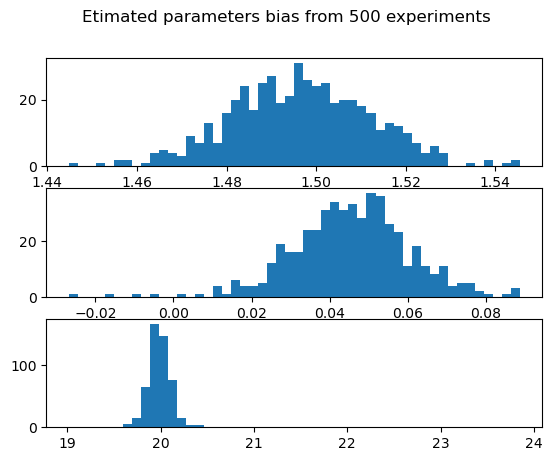

life time has a bias of -0.002 with bias precesion of 0.001
V parameter has bias of -0.057  with bias precesion of 0.001
del parameter has bias of -0.010  with bias precesion of 0.010


In [56]:
fig, axs = plt.subplots(3)
fig.suptitle('Etimated parameters bias from 500 experiments')
axs[0].hist(data_lifetime_4,bins=50)
axs[1].hist(data_V_parm_4,bins=50)
axs[2].hist(data_del_m_parm_4,bins=50)
plt.show()


print(f'life time has a bias of {np.mean(data_lifetime_4)-np.mean(data_lifetime_1):.3f} with bias precesion of {(np.std(data_lifetime_4)/np.sqrt(500)):.3f}')
print(f'V parameter has bias of {np.mean(data_V_parm_4)-np.mean(data_V_parm_1):.3f}  with bias precesion of {(np.std(data_V_parm_4))/np.sqrt(500):.3f}')
print(f'del parameter has bias of {np.mean(data_del_m_parm_4)-np.mean(data_del_m_parm_1):.3f}  with bias precesion of {(np.std(data_del_m_parm_4))/np.sqrt(500):.3f}')

As time resolution is increased, Bias on V parameter increased quaite a lot.

Discussion on bias on v parameter with time resolution.

As V parametr is representing the height of sine function. With a low time resolution, sine function is expected to flatten. As values near the maxima and minima will spread towards middle. And our analysis has verified our intuation.

# Question 3

Estimating a systematic error due to time acceptance 

The method of measuring decay-time (i.e. in some detector) is thought to exhibit a decay-timeacceptance given by a(t) = (1 + st), where s is only known with a precision of s = 0 ± 0.03


Generating the standard data again.

In [13]:
fifth=function_generator(0,10,100000,1.5,0.1,20,0)
dat5=np.array(fifth.funct_dataset())

#Note that we will not generate data again, As we are not concern with statistical precesion or confidence in results for this question.

We will define a new system function specifically for this question which also includes the factor for time acceptance

In [11]:
def funct_sys_new(x,life_time,V_parm,del_m_parm,s):
    def funct(x,life_time,V_parm,del_m_parm):
        return (1+V_parm*np.sin(del_m_parm*x))*np.exp(-x/life_time)*(1+s*x)
    def funct_nor(x):
        return quad(funct,0,10,args=(life_time,V_parm,del_m_parm))   
    return funct(x,life_time,V_parm,del_m_parm)/funct_nor(x)[0]

We will use the shift method to calculate systematic error introduced by less knowledge of time acceptance.

Pick random values of S from a Gaussian distribution centred on 0 with width 0.03
• Then re-run your fit with each S and measure the set of shifts it induces on the best fit physics 
parameters as usual.
• Plot this set of Shifti
• This should give a Gaussian distribution
• Take the standard deviation as the systematic error 

In [14]:
data_lifetime_5=[]
data_V_parm_5=[]
data_del_m_parm_5=[]
n=0


for i in range(500):
    x=np.random.normal(0,0.03)
    #generation random value of S
    
   
    def fnct1(life_time,V_parm,del_m_parm):
        pdf = funct_sys_new(dat5,life_time,V_parm,del_m_parm,x)
        pdf=np.maximum(pdf,0.0001)
        return -np.sum(np.log(pdf))
    
    les1=Minuit(fnct1,life_time=1.5,V_parm=0.1,del_m_parm=20)
    les1.errordef=0.5
    les1.migrad()
    #We estimated the parameters with given time acceptance knowlege.
    
    
    n  += 1
    
    data_lifetime_5.append(les1.values[0])
    data_V_parm_5.append(les1.values[1])
    data_del_m_parm_5.append(les1.values[2])
    print(f'{n})  {les1.values[0]}    {les1.values[1]}     {les1.values[2]}')
    #Keeping track of estimations from each each random value of s

1)  1.705606068781859    0.10387192551147767     19.99884011129898
2)  1.4970032104426094    0.10300844354396263     19.999331470881337
3)  1.500662157803007    0.10301025167140135     19.999329634431277
4)  1.458566865722258    0.10306163872901893     19.999324680263662
5)  1.5347406825125225    0.10305269201757003     19.999311723130578
6)  1.5652848586859511    0.10313596031869236     19.999272318523666
7)  1.477770272294856    0.10303052426052717     19.9993334965909
8)  1.3598417618490701    0.1035687434003208     19.99913068126993
9)  1.5080451887447173    0.10302178896229364     19.99932712678975
10)  1.5034655612565415    0.10300843190188269     19.999268839420978
11)  1.5000615199565956    0.10301009761268744     19.99932941572456
12)  1.68635080157556    0.10374763585962471     19.998903388186555
13)  1.5553688569198922    0.10310394124706164     19.999287267433097
14)  1.432763360856629    0.1031050962743935     19.999289997272477
15)  1.3967408033215554    0.103283632754407

120)  1.47283967436837    0.10301896679763799     19.999326857526235
121)  1.5161316952809005    0.10303053465320082     19.99932041309324
122)  1.6073675638016247    0.10329631618850621     19.999187813231856
123)  1.4549923874483728    0.10304659993569967     19.99931495463852
124)  1.5128403010212184    0.10302725883428072     19.999323222827858
125)  1.5263200311929161    0.1030422896577989     19.99931023659911
126)  1.4268159736668813    0.10312554985433282     19.99928134186869
127)  1.4605538380607028    0.10305739132078172     19.999325907203556
128)  1.5475128998523735    0.10308255194769124     19.999298070173744
129)  1.5291587075415645    0.1030461836935007     19.999306943074398
130)  1.4066779158416833    0.10322606507883283     19.999247723083194
131)  1.4973778136629086    0.1030079999075599     19.99933127643143
132)  1.4963296228354743    0.10300948125014152     19.999331749433274
133)  1.478584288072358    0.10302955461467381     19.999333575605494
134)  1.419625152

237)  1.597108961139986    0.10325101219565894     19.999212208115235
238)  1.486078201270307    0.10302189331467881     19.999333601479016
239)  1.3979830219487008    0.10327601556593753     19.99922988378608
240)  1.487830964853987    0.1030202832798346     19.99933343020565
241)  1.508628394890079    0.10302259626197183     19.999326649482306
242)  1.5280875491486008    0.10304468104069588     19.99930821039679
243)  1.4247143503478261    0.10313329306886657     19.999278081305384
244)  1.365139273457034    0.10352045854471602     19.999146527490645
245)  1.5100804702955022    0.10302436793370554     19.99932547258211
246)  1.5169585523103588    0.10303137714672381     19.999319675924426
247)  1.5146872588777283    0.10302908983586295     19.99932166888843
248)  1.4349274025481766    0.10309817654011998     19.9992929378582
249)  1.5951832119784046    0.10324286508207987     19.999216536015766
250)  1.5236129913983143    0.10303883886896527     19.99931318517297
251)  1.381354180627

354)  1.7229769519239637    0.10399388867990371     19.99875709666186
355)  1.4672076913717413    0.10302573708602544     19.99932400236875
356)  1.4111708887777852    0.10318999153775872     19.999254519189357
357)  1.60206906298651    0.10327252149054689     19.999200694384424
358)  1.4004548258899652    0.1032612196191148     19.999235133581674
359)  1.5376816159136335    0.10305892337894124     19.99930889559872
360)  1.4425593573802078    0.10307592589845774     19.99930242476131
361)  1.5146034442993153    0.10302900670727821     19.99932174058862
362)  1.4367699578668942    0.10309249983910028     19.99929535412316
363)  1.4548604746786309    0.1030468665823919     19.99931484041246
364)  1.507358225488723    0.10302073774680601     19.999327694983446
365)  1.568859167892313    0.10314861977394585     19.999266401565816
366)  1.446938985551298    0.10306463463229765     19.99930725081308
367)  1.419527221809849    0.10315359350035097     19.9992695800458
368)  1.5247297823787   

471)  1.7267515627509042    0.10402099283575982     19.998738209388527
472)  1.5037877586776447    0.10299392706876136     19.99926841765747
473)  1.5141515338584004    0.10302855915186444     19.99932212512015
474)  1.4954985927957023    0.1030109200183972     19.99933201178195
475)  1.4844875093067444    0.1030233755349877     19.999333700472786
476)  1.4815052689121244    0.1030263289981101     19.99933373551074
477)  1.51404827539618    0.10302845698110397     19.999322212506243
478)  1.634956726979914    0.1034523506537859     19.999110011169464
479)  1.4416068390724892    0.10307852271844861     19.99930131565617
480)  1.457115429579686    0.10306489382031998     19.999323720407425
481)  1.4801770540481394    0.10302774899559468     19.999333686755634
482)  1.5786411100352054    0.10318623130611061     19.999248775170052
483)  1.517965868179771    0.1030324239742787     19.999318758568776
484)  1.456591602086023    0.10306610053384554     19.999323360810063
485)  1.57121320738657

Interpreting results

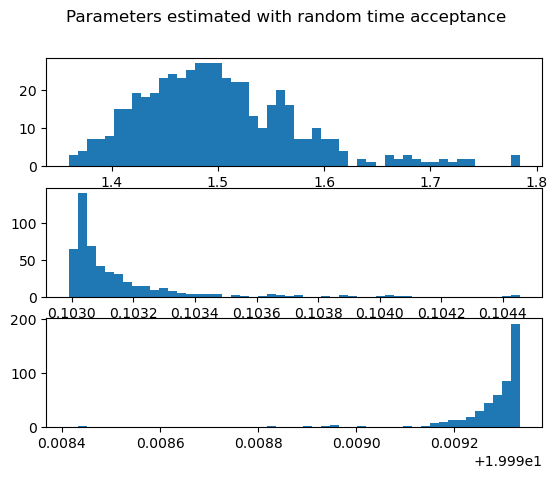

systematic error on life time is +- 0.074
systematic error on V parameter is +- 0.000
systematic error on Del parameter is +- 0.000

wheareas statistical error with 10,000 events estimated in first part is

 Statistical error on life time is +- 0.015 
 Statistical error on V parameter is  +- 0.014 
 Statistical error on Del parameter is  +- 0.074 


In [61]:
fig, axs = plt.subplots(3)
fig.suptitle('Parameters estimated with random time acceptance')
axs[0].hist(data_lifetime_5,bins=50)
axs[1].hist(data_V_parm_5,bins=50)
axs[2].hist(data_del_m_parm_5,bins=50)
plt.show()


print(f'systematic error on life time is +- {np.std(data_lifetime_5):.3f}')
print(f'systematic error on V parameter is +- {np.std(data_V_parm_5):.3f}')
print(f'systematic error on Del parameter is +- {np.std(data_del_m_parm_5):.3f}')

print()
print('wheareas statistical error with 10,000 events estimated in first part is')
print()

print(f' Statistical error on life time is +- {np.std(data_lifetime_1):.3f} ')
print(f' Statistical error on V parameter is  +- {np.std(data_V_parm_1):.3f} ')
print(f' Statistical error on Del parameter is  +- {np.std(data_del_m_parm_1):.3f} ')

Discussion on results

Nature of time acceptance is simple straingh line. and its slope is known with some uncertainty. So it is unlikely that this uncertainity with make a difference in period of sine function (del m parameters). And it is also unlikely (although I have less confifence in this claim) that it will make difference to height of sine function (V parameters). But this acceptance is likely to make a difference in time constant of exponential decay.(Get intuation from graphical calculator). 

This claim is well supported by our analysis, where systematic error is only introduced to life time parameter.